## Imports
Execute the cell below to import all packages needed.

In [1]:
# System functionality
import sys
sys.path.append('..')

import glob
import os
import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import graphviz
import math as math
import json
import cv2
import matplotlib.image as mpimg
from skimage import data, io, filters
from numpy import linspace
from numpy.core.umath import pi
from matplotlib.ticker import FuncFormatter
from matplotlib.font_manager import FontProperties
from emoji_extractor.extract import Extractor
from emojipedia import Emojipedia
from skimage import io

## Load csv into pandas dataframe

In [2]:
path__tweets_csv = '/home/stelios/Desktop/Honours Project/Samples/tweet_data/tweets_ran_all.csv'
path_users_csv = '/home/stelios/Desktop/Honours Project/Samples/user_data/ran.csv'

#ran_tweets_df = pd.read_csv(path__tweets_csv,index_col=None, header=0, low_memory = False).applymap(str)
#ran_users_df = pd.read_csv(path_users_csv,index_col=None, header=0, low_memory = False).applymap(str)

ran_join_df = pd.read_csv(path__tweets_csv,index_col=None, header=0, low_memory = False).applymap(str).join(pd.read_csv(path_users_csv,index_col=None, header=0, low_memory = False).applymap(str).set_index('user_id'), on='user_id')

## Bar Chart Formatters

In [3]:
# Millions Formatter Function
def millions(x,pos):
    return '%1.1fK' % (x*1e-3)

# Power of 10 Formatter Function (y log scale bug, so i have created this formatter)
def pow10(x,pos):
    return "{:.0f}\n10 ".format(x)

# Power of 10 (1 d.p) Formatter Function (y log scale bug, so i have created this formatter)
def pow10_1dp(x,pos):
    return "{:.1f}\n10     ".format(x)

# Percenatge Formatter Function
def percentage(x,pos):
    return "{:.1f}%".format(x*100)

# Create a formatters
formatter_millions = FuncFormatter(millions)
formatter_pow10 = FuncFormatter(pow10)
formatter_pow10_1dp = FuncFormatter(pow10_1dp)
formatter_percentage = FuncFormatter(percentage)

# Use TwitterColorEmoji Font (only one supporting emojis) 
emojis_font = FontProperties(fname='./Fonts/TwitterColorEmoji-SVGinOT.ttf',size=55)

## Colours

In [4]:
colors_seagreen_fade=["#f3f8f3","#e8f1e8","#ddeadd","#d2e4d2","#c7ddc7","#bbd6bb","#b0d0b0","#a5c9a5","#9ac29a","#8fbc8f","#80a980","#729672","#648364","#557055","#475e47","#394b39"]

colors_orange_fade=["#fff6e5","#ffedcc","#ffe4b2","#ffdb99","#ffd27f","#ffc966","#ffc04c","#ffb732","#ffae19","#ffa500","#e59400","#cc8400","#b27300","#996300","#7f5200","#664200"]

colors_dodgeblue_fade=["#e7f1fa","#d0e3f5","#b9d5f0","#a2c7eb","#8bb9e6","#74abe1","#5d9ddc","#468fd7","#2f81d2","#1874cd","#1568b8","#135ca4","#10518f","#0e457b","#0c3a66","#092e52"]

colors_indianred_fade=["#faeeee","#f5dddd","#f0cccc","#ebbbbb","#e6aaaa","#e19999","#dc8888","#d77676","#d26666","#cd5555","#b84c4c","#a44444","#8f3b3b","#7b3333","#662a2a","#522222"]

## Emojis on Pie Chart Function

In [5]:
def pie_chart_plot_emojis(ax,fig,x):
    # Set sizes of figure and images
    ax_width = ax.get_window_extent().width
    fig_width = fig.get_window_extent().width
    fig_height = fig.get_window_extent().height
    img_size = ax_width/(fig_width*len(x_linespace))
    img_axs = [None for i in range(len(x_linespace))]

    y_manual = 0.843
    loc = ax.transData.transform((1.88, y_manual))
    img_axs[0] = fig.add_axes([loc[0]/fig_width-img_size/2, loc[1]/fig_height-img_size/2, img_size, img_size], anchor='C')
    img_axs[0].imshow(io.imread("/home/stelios/Desktop/Honours Project/Emojis-usage-in-social-media-by-demographics/Jupyter/Fonts&Pics/other_less.png"))
    img_axs[0].axis("off")
    y_manual =y_manual-0.1408

    # Display emojis pngs on x-axis
    for i in range(len(x)):
        loc = ax.transData.transform((1.88, y_manual))      # Optimize y manually 
        img_axs[i] = fig.add_axes([loc[0]/fig_width-img_size/2, loc[1]/fig_height-img_size/2, img_size, img_size], anchor='C')
        y_manual =y_manual-0.1408
        # Platform 5 = Twitter
        img_axs[i].imshow(io.imread(Emojipedia.search(x[i]).platforms[5].image_url))
        img_axs[i].axis("off")

## Emojis on Bar Chart Function

In [6]:
def bar_chart_plot_emojis(ax,fig,x):
    # Set sizes of figure and images
    ax_width = ax.get_window_extent().width
    fig_width = fig.get_window_extent().width
    fig_height = fig.get_window_extent().height
    img_size = ax_width/(fig_width*len(x_linespace))
    img_axs = [None for i in range(len(x_linespace))]

    # Display emojis pngs on x-axis
    for i in range(len(x)):
        loc = ax.transData.transform((x_linespace[i], 0))      # Optimize y manually 
        img_axs[i] = fig.add_axes([loc[0]/fig_width-img_size/2, loc[1]/fig_height-img_size/2,
                                   img_size, img_size], anchor='C')

        # Platform 5 = Twitter
        img_axs[i].imshow(io.imread(Emojipedia.search(x[i]).platforms[5].image_url))
        img_axs[i].axis("off")

## Extract, Count & Sort Emojis for all

In [7]:
extract = Extractor()

count = extract.count_all_emoji(ran_join_df['text'])

# Display most common
#count.most_common()

# Create panda dataframe to store emojis with counts
emojis_count_df = pd.DataFrame(columns = ['Emoji','Count'])
for emoji in count:
    emojis_count_df = emojis_count_df.append({'Emoji' : emoji , 'Count' : count[emoji]} , ignore_index=True)

# Sort dataframe by count
emojis_count_df = emojis_count_df.sort_values(by=['Count'])
emojis_count_df.tail(20)

,Emoji,Count
99,💗,33495
135,🙄,36686
21,💙,38404
28,🙏,38783
151,♥,38865
2,👍,39711
36,😘,42422
26,👏,46411
50,🔥,50812
9,🤔,51281


## Top 15 Emojis Graph

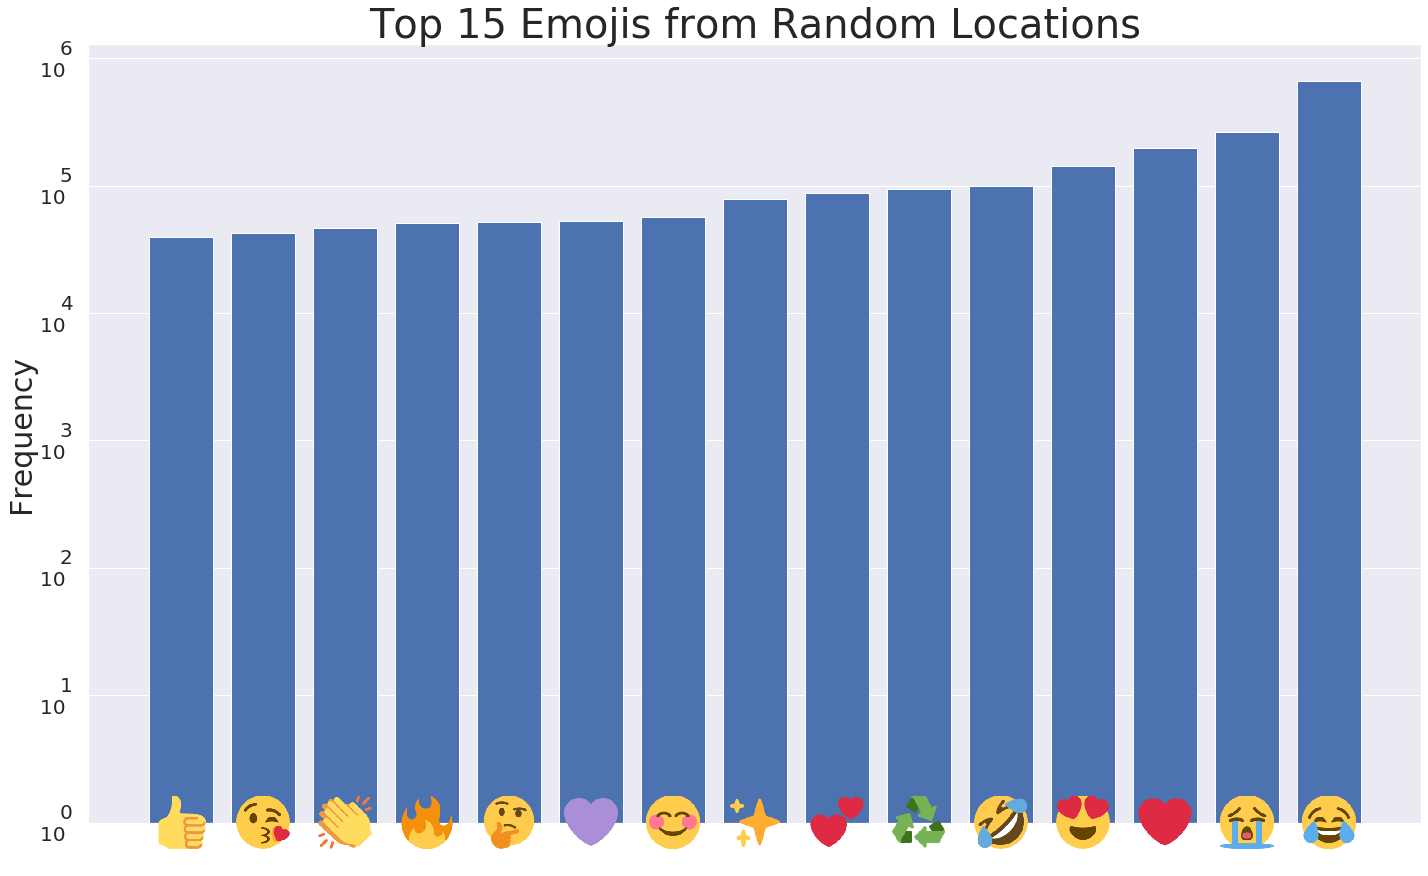

In [8]:
# Top 15 Values
x = emojis_count_df['Emoji'].tail(15).values
y = emojis_count_df['Count'].tail(15).values
y_log = np.log10(y.astype(int))

# Set linespacing
x_linespace = linspace(0, 4*pi, num=15)

# Plot Bar Chart
sns.set(color_codes=True) # Seaborn 
fig, ax = plt.subplots(figsize=(20,12))
ax.yaxis.set_major_formatter(formatter_pow10)
ax.tick_params(axis='both', which='major', pad=10)
#ax.set_facecolor('#dbd9d9')
plt.grid(linestyle='-', linewidth=1,axis='y')
plt.bar(x_linespace, y_log, width=0.7, bottom=None, align='center')#,color =colors_indianred_fade)
ax.get_xaxis().set_visible(False)
plt.yticks(fontsize =20)
plt.ylabel('Frequency', fontsize =30)
plt.title('Top 15 Emojis from Random Locations', fontsize =40)
plt.tight_layout()

# Plot emojis on x-axis
bar_chart_plot_emojis(ax,fig,x)
plt.show()

## Extract, Count & Sort Emojis for females

In [9]:
# Count emojis (Gender Confidence =1)
count_females = extract.count_all_emoji(ran_join_df.loc[(ran_join_df['gender'] == 'female')& (ran_join_df['gender:confidence'].astype(float)==1)]['text'])

# Create panda dataframe to store emojis with counts
emojis_count_females_df = pd.DataFrame(columns = ['Emoji','Count'])
for emoji in count_females:
    emojis_count_females_df = emojis_count_females_df.append({'Emoji' : emoji , 'Count' : count_females[emoji]} , ignore_index=True)

# Sort dataframe by count
emojis_count_females_df = emojis_count_females_df.sort_values(by=['Count'])
emojis_count_females_df.tail(20)

,Emoji,Count
117,🤔,4451
151,🙏,4526
1256,◀,4627
38,💛,4769
26,💖,4929
49,👏,5096
27,💗,5796
108,💔,5944
279,💙,6082
83,😘,6607


## Extract, Count & Sort Emojis for males

In [10]:
# Count emojis (Gender Confidence =1)
count_males = extract.count_all_emoji(ran_join_df.loc[(ran_join_df['gender'] == 'male')& (ran_join_df['gender:confidence'].astype(float)==1)]['text'])

# Create panda dataframe to store emojis with counts
emojis_count_males_df = pd.DataFrame(columns = ['Emoji','Count'])
for emoji in count_males:
    emojis_count_males_df = emojis_count_males_df.append({'Emoji' : emoji , 'Count' : count_males[emoji]} , ignore_index=True)

# Sort dataframe by count
emojis_count_males_df = emojis_count_males_df.sort_values(by=['Count'])
emojis_count_males_df.tail(20)

,Emoji,Count
8,😢,2294
43,✨,2301
26,😩,2554
4,👍,2683
91,🙄,2758
1,💙,2798
127,😁,2961
39,🙏,3539
41,👏,3625
115,🤔,3681


## Dinstict Emojis per Gender

In [11]:
gender_stats_df = emojis_count_females_df.rename(columns={'Count': 'Females_Count'}).join(emojis_count_males_df.rename(columns={'Count': 'Males_Count'}).set_index('Emoji'), on='Emoji')

# Calculate percentage usage for each emoji per gender
female_count_perc = gender_stats_df['Females_Count'] /gender_stats_df['Females_Count'].sum()
gender_stats_df['Females_Count_Perc']=female_count_perc
male_count_perc = gender_stats_df['Males_Count'] /gender_stats_df['Males_Count'].sum()
gender_stats_df['Males_Count_Perc']=male_count_perc
male_perc_dif = gender_stats_df['Males_Count_Perc'] - gender_stats_df['Females_Count_Perc']
gender_stats_df['Males_Perc_Dif']=male_perc_dif
female_perc_dif = gender_stats_df['Females_Count_Perc'] - gender_stats_df['Males_Count_Perc']
gender_stats_df['Females_Perc_Dif']=female_perc_dif

gender_stats_df.tail(20)

,Emoji,Females_Count,Males_Count,Females_Count_Perc,Males_Count_Perc,Males_Perc_Dif,Females_Perc_Dif
117,🤔,4451,3681,0.00822461,0.0108886,0.00266399,-0.00266399
151,🙏,4526,3539,0.00836319,0.0104686,0.00210537,-0.00210537
1256,◀,4627,NaN,0.00854982,NaN,NaN,NaN
38,💛,4769,1709,0.00881221,0.00505532,-0.00375689,0.00375689
26,💖,4929,1654,0.00910786,0.00489262,-0.00421524,0.00421524
49,👏,5096,3625,0.00941644,0.0107229,0.00130651,-0.00130651
27,💗,5796,1048,0.0107099,0.00310004,-0.00760987,0.00760987
108,💔,5944,1361,0.0109834,0.00402591,-0.00695747,0.00695747
279,💙,6082,2798,0.0112384,0.00827664,-0.00296175,0.00296175
83,😘,6607,2147,0.0122085,0.00635094,-0.00585754,0.00585754


## Top 15 Emojis Graph by Gender

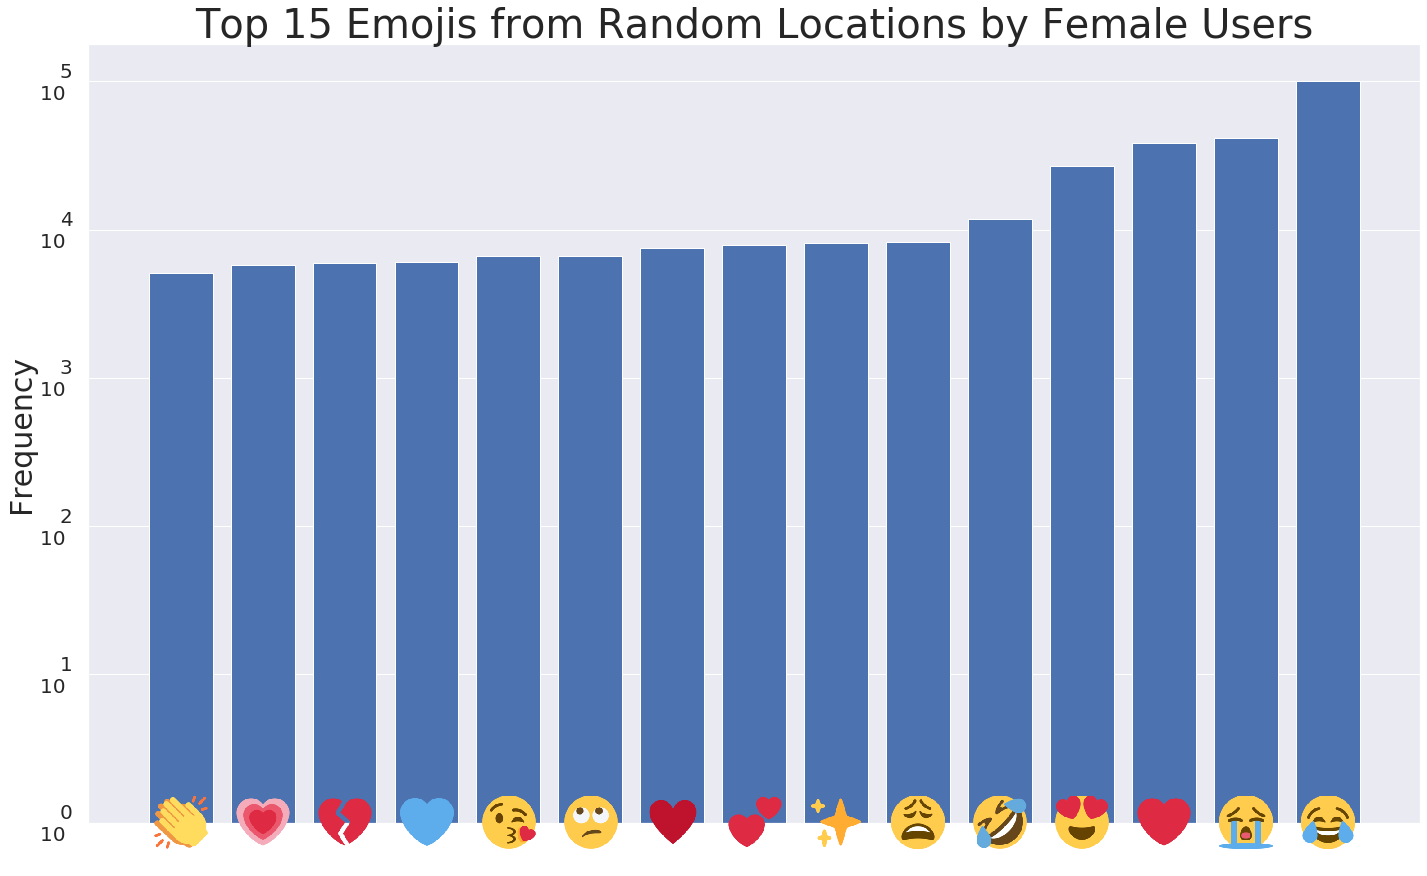

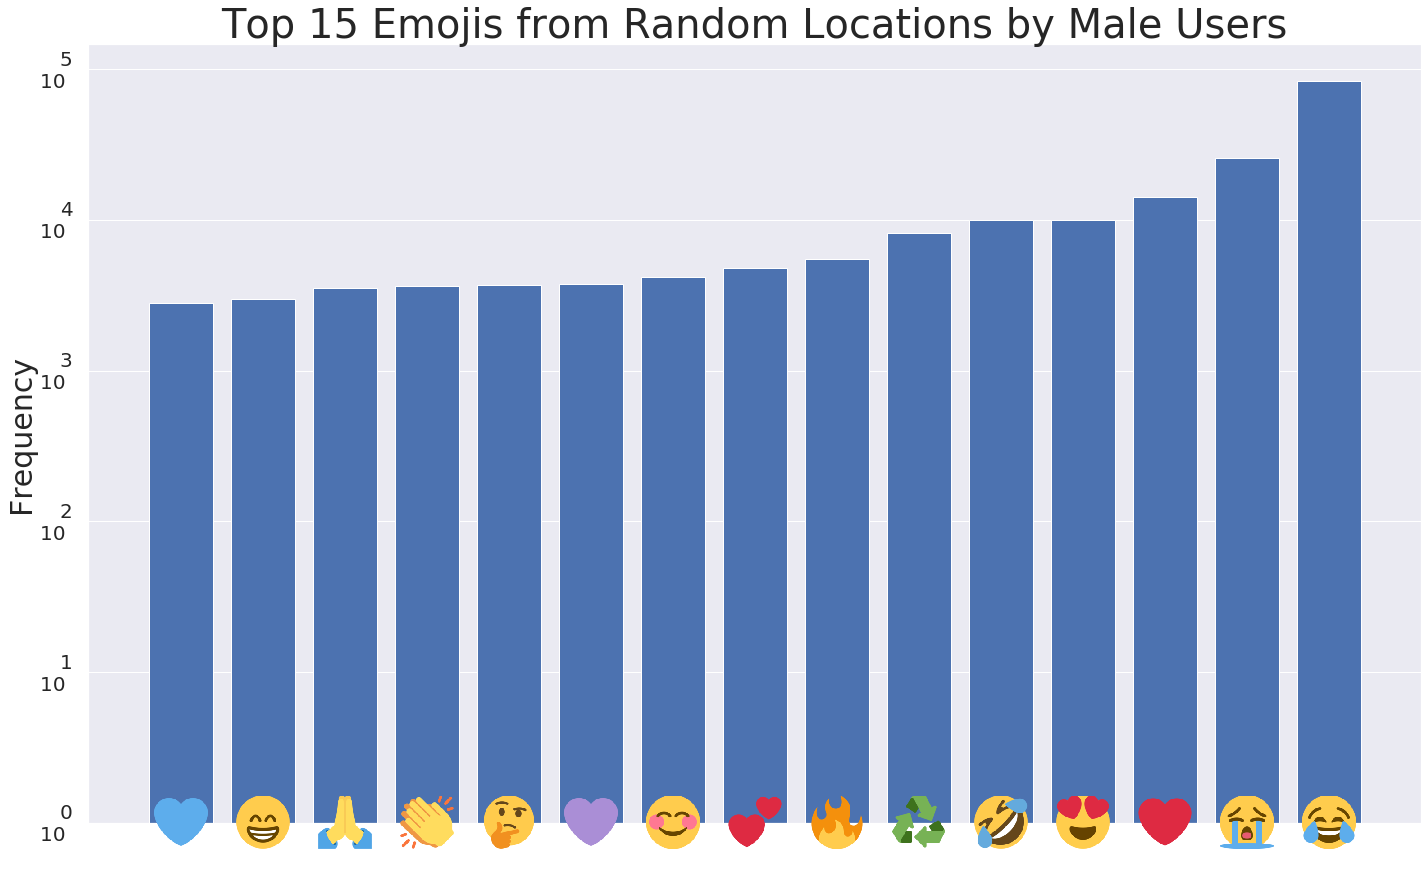

In [12]:
gender_list = ['Female','Male']
gender_values =[emojis_count_females_df,emojis_count_males_df]
#gender_graph_colours=['ffe9ec','6992C2']

for ind,gen in enumerate(gender_list):
    
    # Top 15 Values
    x = gender_values[ind]['Emoji'].tail(15).values
    y = gender_values[ind]['Count'].tail(15).values
    y_log = np.log10(y.astype(int))

    # Set linespacing
    x_linespace = linspace(0, 4*pi, num=15)

    # Plot Bar Chart
    fig, ax = plt.subplots(figsize=(20,12))
    ax.yaxis.set_major_formatter(formatter_pow10)
    ax.tick_params(axis='both', which='major', pad=10)
   # ax.set_facecolor('#{}'.format(gender_graph_colours[ind]))
    plt.grid(linestyle='-', linewidth=1,axis='y')
    plt.bar(x_linespace, y_log, width=0.7, bottom=None, align='center')#,color =colors_indianred_fade)
    ax.get_xaxis().set_visible(False)
    #plt.xticks(x, fontproperties=emojis_font)  Old method
    plt.yticks(fontsize =20)
    plt.ylabel('Frequency', fontsize =30)
    plt.title('Top 15 Emojis from Random Locations by {} Users'.format(gender_list[ind]), fontsize =40)
    plt.tight_layout()

    # Plot emojis on x-axis
    bar_chart_plot_emojis(ax,fig,x)
    plt.show()

## Top 15 Dinstinct Emojis by Gender

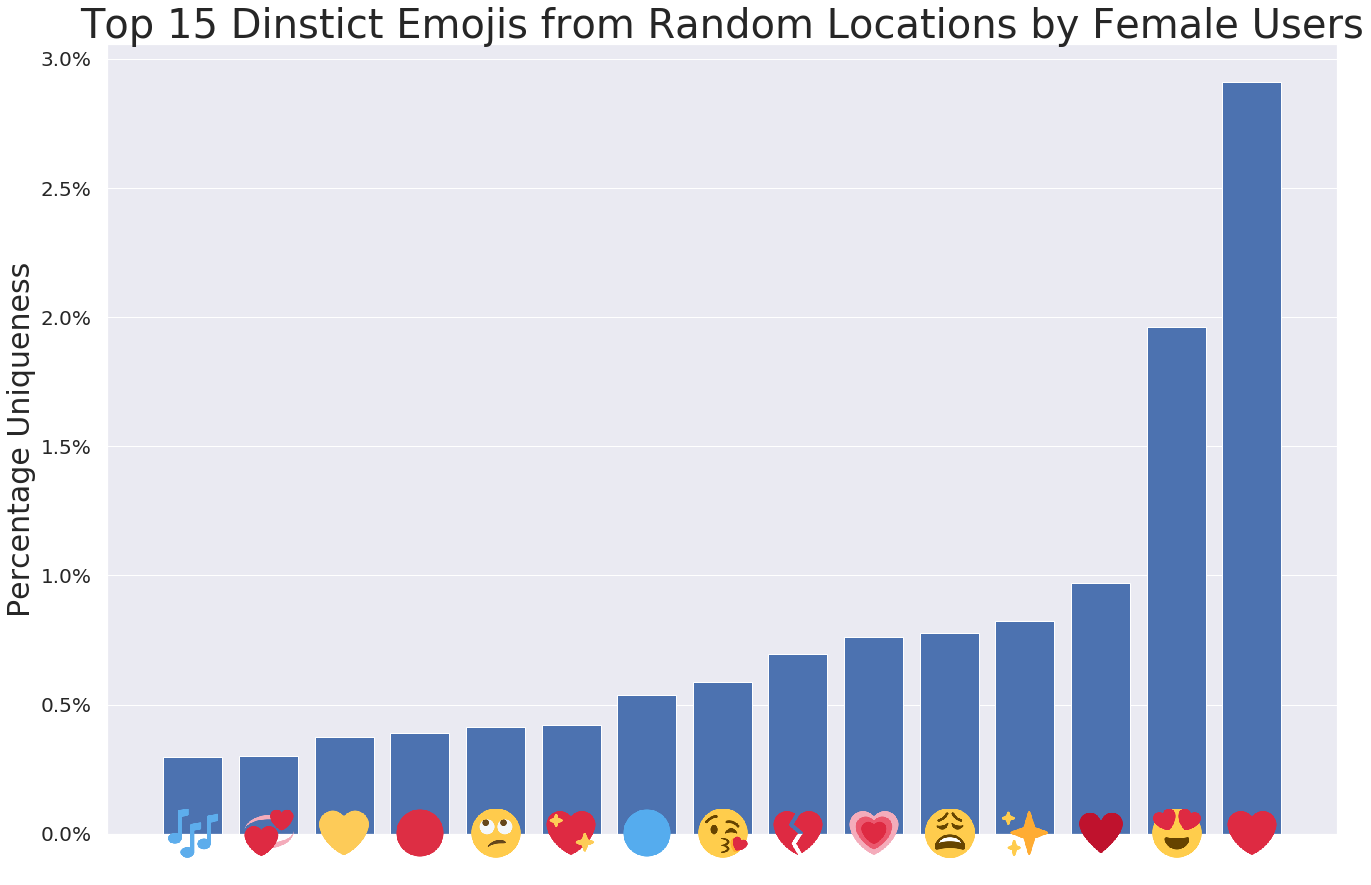

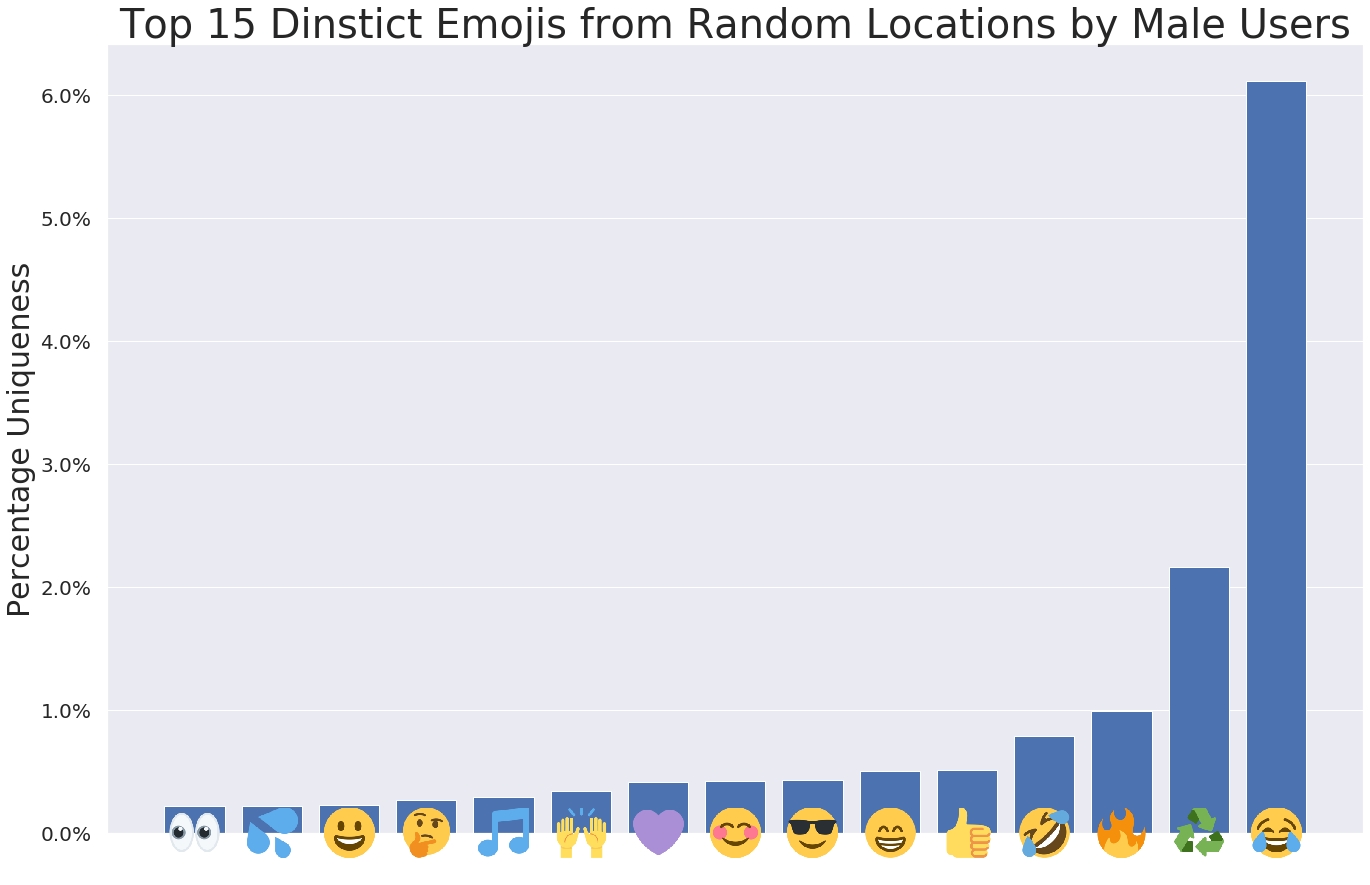

In [13]:
gender_list = ['Female','Male']
gender_values =[gender_stats_df.fillna(0).sort_values(by=['Females_Perc_Dif']),gender_stats_df.fillna(0).sort_values(by=['Males_Perc_Dif'])]
#gender_graph_colours=['ffe9ec','6992C2']

for ind,gen in enumerate(gender_list):
    
    # Top 15 Values
    x = gender_values[ind]['Emoji'].tail(15).values
    y = gender_values[ind]['{}s_Perc_Dif'.format(gender_list[ind])].tail(15).values
    
    # Set linespacing
    x_linespace = linspace(0, 4*pi, num=15)

    # Plot Bar Chart
    fig, ax = plt.subplots(figsize=(20,12))
    ax.yaxis.set_major_formatter(formatter_percentage)
    ax.tick_params(axis='both', which='major', pad=10)
   # ax.set_facecolor('#{}'.format(gender_graph_colours[ind]))
    plt.grid(linestyle='-', linewidth=1,axis='y')
    plt.bar(x_linespace, y, width=0.7, bottom=None, align='center')#,color =colors_indianred_fade)
    ax.get_xaxis().set_visible(False)
    #plt.xticks(x, fontproperties=emojis_font)  Old method
    plt.yticks(fontsize =20)
    plt.ylabel('Percentage Uniqueness', fontsize =30)
    plt.title('Top 15 Dinstict Emojis from Random Locations by {} Users'.format(gender_list[ind]), fontsize =40)
    plt.tight_layout()

    # Plot emojis on x-axis
    bar_chart_plot_emojis(ax,fig,x)

    plt.show()

## Extract, Count & Sort Emojis for White Ethnicity

In [14]:
# Count emojis (Ethnicity Confidence: 0.75)
count_white = extract.count_all_emoji(ran_join_df.loc[(ran_join_df['ethnicity'] == 'white')& (ran_join_df['ethnicity:confidence'].astype(float)>0.75)]['text'])
count_not_white =extract.count_all_emoji(ran_join_df.loc[(ran_join_df['ethnicity'] != 'white')& (ran_join_df['ethnicity:confidence'].astype(float)>0.75)]['text'])

# Create panda dataframe to store emojis with counts

# Whites
emojis_count_white_df = pd.DataFrame(columns = ['Emoji','Whites_Count'])
for emoji in count_white:
    emojis_count_white_df = emojis_count_white_df.append({'Emoji' : emoji , 'Whites_Count' : count_white[emoji]} , ignore_index=True)

# Not Whites
emojis_count_not_white_df = pd.DataFrame(columns = ['Emoji','Not_Whites_Count'])
for emoji in count_not_white:
    emojis_count_not_white_df = emojis_count_not_white_df.append({'Emoji' : emoji , 'Not_Whites_Count' : count_not_white[emoji]} , ignore_index=True)    

# White Stats
white_stats_df = emojis_count_white_df.join(emojis_count_not_white_df.set_index('Emoji'), on='Emoji')

# Calculate percentage usage for each emoji per ethnicity
white_count_perc = white_stats_df['Whites_Count'] /white_stats_df['Whites_Count'].sum()
white_stats_df['Whites_Count_Perc']=white_count_perc
not_white_count_perc = white_stats_df['Not_Whites_Count'] /white_stats_df['Not_Whites_Count'].sum()
white_stats_df['Not_Whites_Count_Perc']=not_white_count_perc
white_perc_dif = white_stats_df['Whites_Count_Perc'] - white_stats_df['Not_Whites_Count_Perc']
white_stats_df['Whites_Perc_Dif']=white_perc_dif
not_white_perc_dif = white_stats_df['Not_Whites_Count_Perc'] - white_stats_df['Whites_Count_Perc']
white_stats_df['Not_Whites_Perc_Dif']=not_white_perc_dif

white_stats_df = white_stats_df.fillna(0).sort_values(by=['Whites_Perc_Dif'])
white_stats_df.tail(20)

,Emoji,Whites_Count,Not_Whites_Count,Whites_Count_Perc,Not_Whites_Count_Perc,Whites_Perc_Dif,Not_Whites_Perc_Dif
11,😀,1217,308,0.003686,0.000703,0.002983,-0.002983
217,💚,2745,2238,0.008313,0.005108,0.003205,-0.003205
22,💖,3337,3013,0.010106,0.006876,0.003229,-0.003229
24,💞,2027,1218,0.006139,0.002780,0.003359,-0.003359
379,👏🏻,1353,275,0.004097,0.000628,0.003470,-0.003470
169,👇,1420,114,0.004300,0.000260,0.004040,-0.004040
47,🤗,2714,1820,0.008219,0.004154,0.004065,-0.004065
233,⭐,1790,592,0.005421,0.001351,0.004070,-0.004070
5,😉,2185,945,0.006617,0.002157,0.004460,-0.004460
45,👏,3294,2390,0.009976,0.005454,0.004521,-0.004521


## Extract, Count & Sort Emojis for Black Ethnicity

In [15]:
# Count emojis (Ethnicity Confidence: 0.75)
count_black = extract.count_all_emoji(ran_join_df.loc[(ran_join_df['ethnicity'] == 'black')& (ran_join_df['ethnicity:confidence'].astype(float)>0.75)]['text'])
count_not_black  =extract.count_all_emoji(ran_join_df.loc[(ran_join_df['ethnicity'] != 'black')& (ran_join_df['ethnicity:confidence'].astype(float)>0.75)]['text'])

# Create panda dataframe to store emojis with counts

# Blacks 
emojis_count_black_df = pd.DataFrame(columns = ['Emoji','Blacks_Count'])
for emoji in count_black:
    emojis_count_black_df = emojis_count_black_df.append({'Emoji' : emoji , 'Blacks_Count' : count_black[emoji]} , ignore_index=True)

# Not Blacks
emojis_count_not_black_df = pd.DataFrame(columns = ['Emoji','Not_Blacks_Count'])
for emoji in count_not_black:
    emojis_count_not_black_df = emojis_count_not_black_df.append({'Emoji' : emoji , 'Not_Blacks_Count' : count_not_black[emoji]} , ignore_index=True)    

# Black Stats
black_stats_df = emojis_count_black_df.join(emojis_count_not_black_df.set_index('Emoji'), on='Emoji')

# Calculate percentage usage for each emoji per ethnicity
black_count_perc = black_stats_df['Blacks_Count'] /black_stats_df['Blacks_Count'].sum()
black_stats_df['Blacks_Count_Perc']=black_count_perc
not_black_count_perc = black_stats_df['Not_Blacks_Count'] /black_stats_df['Not_Blacks_Count'].sum()
black_stats_df['Not_Blacks_Count_Perc']=not_black_count_perc
black_perc_dif = black_stats_df['Blacks_Count_Perc'] - black_stats_df['Not_Blacks_Count_Perc']
black_stats_df['Blacks_Perc_Dif']=black_perc_dif
not_black_perc_dif = black_stats_df['Not_Blacks_Count_Perc'] - black_stats_df['Blacks_Count_Perc']
black_stats_df['Not_Blacks_Perc_Dif']=not_black_perc_dif

black_stats_df = black_stats_df.fillna(0).sort_values(by=['Blacks_Perc_Dif'])
black_stats_df.tail(20)

,Emoji,Blacks_Count,Not_Blacks_Count,Blacks_Count_Perc,Not_Blacks_Count_Perc,Blacks_Perc_Dif,Not_Blacks_Perc_Dif
60,🤦🏽‍♂️,491,134,0.002469,0.000241,0.002228,-0.002228
39,🙏🏽,528,121,0.002655,0.000217,0.002437,-0.002437
14,😫,828,930,0.004163,0.001670,0.002493,-0.002493
37,😹,831,894,0.004178,0.001605,0.002573,-0.002573
66,😒,1269,2032,0.006380,0.003648,0.002732,-0.002732
199,🤦🏾‍♂️,622,4,0.003127,0.000007,0.003120,-0.003120
46,🤷🏾‍♀️,715,9,0.003595,0.000016,0.003579,-0.003579
220,🙌🏾,767,59,0.003856,0.000106,0.003750,-0.003750
224,🙏🏾,833,36,0.004188,0.000065,0.004123,-0.004123
43,👀,1699,2344,0.008542,0.004208,0.004334,-0.004334


## Extract, Count & Sort Emojis for Other and Hispanic Ethnicity

In [16]:
# Count emojis (Ethnicity Confidence: 0.75)
count_other = extract.count_all_emoji(ran_join_df.loc[((ran_join_df['ethnicity'] == 'hispanic')|(ran_join_df['ethnicity'] == 'other'))& (ran_join_df['ethnicity:confidence'].astype(float)>0.75)]['text'])
count_not_other  =extract.count_all_emoji(ran_join_df.loc[(ran_join_df['ethnicity'] != 'hispanic')&(ran_join_df['ethnicity'] != 'other')& (ran_join_df['ethnicity:confidence'].astype(float)>0.75)]['text'])

# Create panda dataframe to store emojis with counts

# Others 
emojis_count_other_df = pd.DataFrame(columns = ['Emoji','Others_Count'])
for emoji in count_other:
    emojis_count_other_df = emojis_count_other_df.append({'Emoji' : emoji , 'Others_Count' : count_other[emoji]} , ignore_index=True)

# Not Others
emojis_count_not_other_df = pd.DataFrame(columns = ['Emoji','Not_Others_Count'])
for emoji in count_not_other:
    emojis_count_not_other_df = emojis_count_not_other_df.append({'Emoji' : emoji , 'Not_Others_Count' : count_not_other[emoji]} , ignore_index=True)    

# Others Stats
other_stats_df = emojis_count_other_df.join(emojis_count_not_other_df.set_index('Emoji'), on='Emoji')

# Calculate percentage usage for each emoji per ethnicity
other_count_perc = other_stats_df['Others_Count'] /other_stats_df['Others_Count'].sum()
other_stats_df['Others_Count_Perc']=other_count_perc
not_other_count_perc = other_stats_df['Not_Others_Count'] /other_stats_df['Not_Others_Count'].sum()
other_stats_df['Not_Others_Count_Perc']=not_other_count_perc
other_perc_dif = other_stats_df['Others_Count_Perc'] - other_stats_df['Not_Others_Count_Perc']
other_stats_df['Others_Perc_Dif']=other_perc_dif
not_other_perc_dif = other_stats_df['Not_Others_Count_Perc'] - other_stats_df['Others_Count_Perc']
other_stats_df['Not_Others_Perc_Dif']=not_black_perc_dif

other_stats_df = other_stats_df.fillna(0).sort_values(by=['Others_Perc_Dif'])
other_stats_df.tail(20)

,Emoji,Others_Count,Not_Others_Count,Others_Count_Perc,Not_Others_Count_Perc,Others_Perc_Dif,Not_Others_Perc_Dif
44,😡,241,2749,0.006160,0.003902,0.002258,0.003002
135,😏,220,2295,0.005623,0.003258,0.002365,0.000013
2,😢,333,4218,0.008511,0.005987,0.002524,-0.000845
465,👑,132,498,0.003374,0.000707,0.002667,0.000513
48,💔,416,5411,0.010633,0.007680,0.002952,-0.005715
493,🙏🏼,148,567,0.003783,0.000805,0.002978,-0.000015
194,👏,412,5272,0.010530,0.007483,0.003047,0.002905
169,🎶,333,3451,0.008511,0.004898,0.003613,-0.000015
197,👌,227,1254,0.005802,0.001780,0.004022,0.000951
128,😒,324,2977,0.008281,0.004226,0.004056,0.000286


## Extract, Count & Sort Emojis for Asian Ethnicity

In [17]:
# Count emojis (Ethnicity Confidence: 0.75)
count_asian = extract.count_all_emoji(ran_join_df.loc[(ran_join_df['ethnicity'] == 'asian')& (ran_join_df['ethnicity:confidence'].astype(float)>0.75)]['text'])
count_not_asian  =extract.count_all_emoji(ran_join_df.loc[(ran_join_df['ethnicity'] != 'asian')&(ran_join_df['ethnicity:confidence'].astype(float)>0.75)]['text'])

# Create panda dataframe to store emojis with counts

# Asians 
emojis_count_asian_df = pd.DataFrame(columns = ['Emoji','Asians_Count'])
for emoji in count_asian:
    emojis_count_asian_df = emojis_count_asian_df.append({'Emoji' : emoji , 'Asians_Count' : count_asian[emoji]} , ignore_index=True)

# Not Asians
emojis_count_not_asian_df = pd.DataFrame(columns = ['Emoji','Not_Asians_Count'])
for emoji in count_not_asian:
    emojis_count_not_asian_df = emojis_count_not_asian_df.append({'Emoji' : emoji , 'Not_Asians_Count' : count_not_asian[emoji]} , ignore_index=True)    

# Asians Stats
asian_stats_df = emojis_count_asian_df.join(emojis_count_not_asian_df.set_index('Emoji'), on='Emoji')

# Calculate percentage usage for each emoji per gender
asian_count_perc = asian_stats_df['Asians_Count'] /asian_stats_df['Asians_Count'].sum()
asian_stats_df['Asians_Count_Perc']=asian_count_perc
not_asian_count_perc = asian_stats_df['Not_Asians_Count'] /asian_stats_df['Not_Asians_Count'].sum()
asian_stats_df['Not_Asians_Count_Perc']=not_asian_count_perc
asian_perc_dif = asian_stats_df['Asians_Count_Perc'] - asian_stats_df['Not_Asians_Count_Perc']
asian_stats_df['Asians_Perc_Dif']=asian_perc_dif
not_asian_perc_dif = asian_stats_df['Not_Asians_Count_Perc'] - asian_stats_df['Asians_Count_Perc']
asian_stats_df['Not_Asians_Perc_Dif']=not_black_perc_dif

asian_stats_df = asian_stats_df.fillna(0).sort_values(by=['Asians_Perc_Dif'])
asian_stats_df.tail(20)

,Emoji,Asians_Count,Not_Asians_Count,Asians_Count_Perc,Not_Asians_Count_Perc,Asians_Perc_Dif,Not_Asians_Perc_Dif
56,👍,1500,1798,0.007399,0.003290,0.004109,3.468500e-02
38,😇,1116,656,0.005505,0.001200,0.004304,-2.981140e-04
207,‼,1349,1276,0.006654,0.002335,0.004319,1.198142e-03
280,💚,2001,2982,0.009870,0.005457,0.004414,-4.237649e-04
74,😁,2430,3482,0.011986,0.006372,0.005615,7.834773e-04
278,🎵,1345,369,0.006634,0.000675,0.005959,1.909268e-04
1,😊,3159,4119,0.015582,0.007537,0.008045,-1.533480e-04
1012,⏩,1768,1,0.008721,0.000002,0.008719,0.000000e+00
272,❗,2074,802,0.010230,0.001468,0.008763,1.004440e-05
157,💦,2178,462,0.010743,0.000845,0.009898,-1.016348e-04


## Top 15 Emojis Graph by Ethnicity

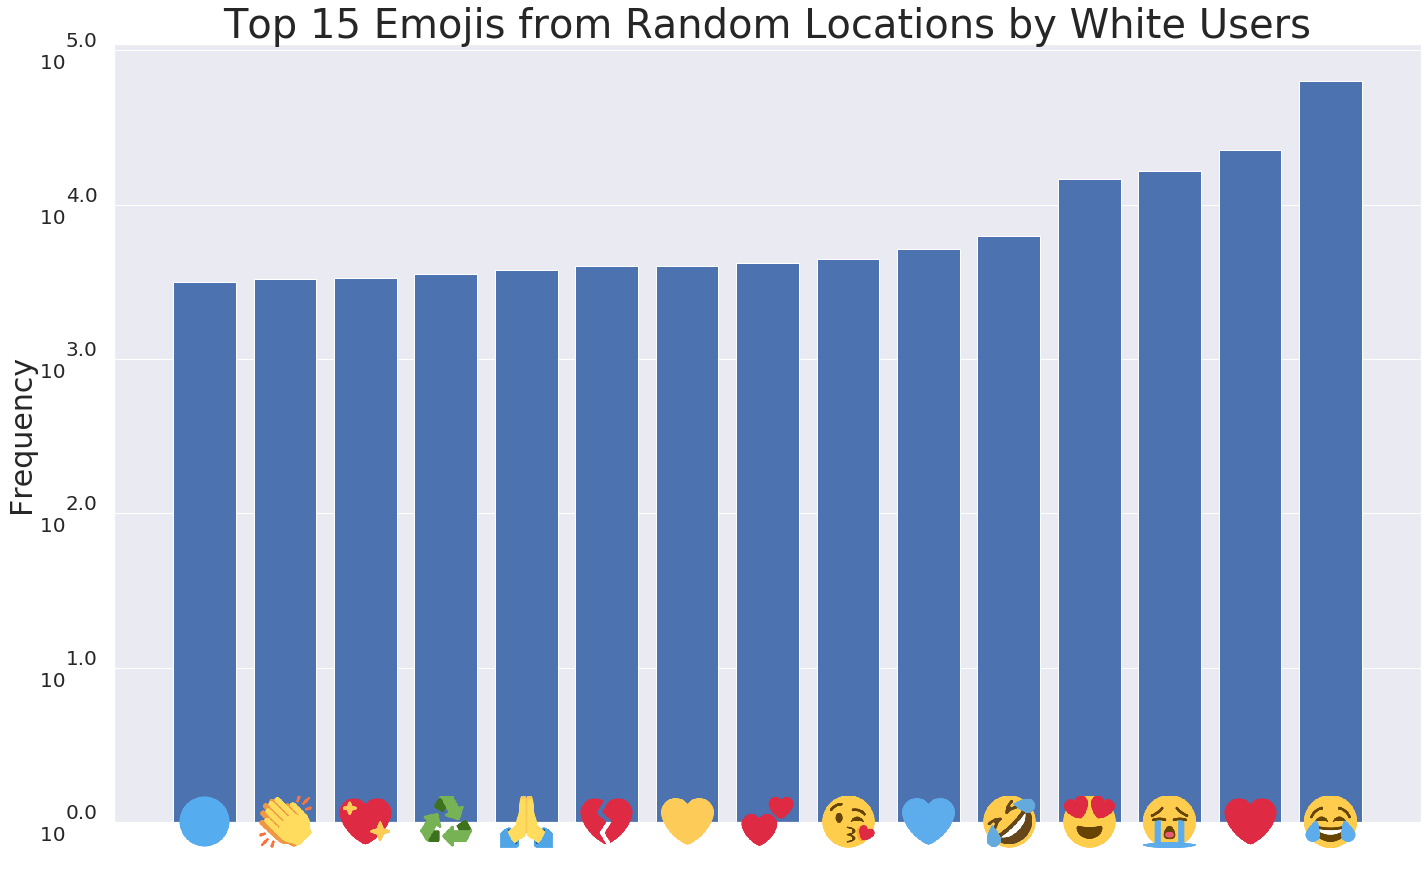

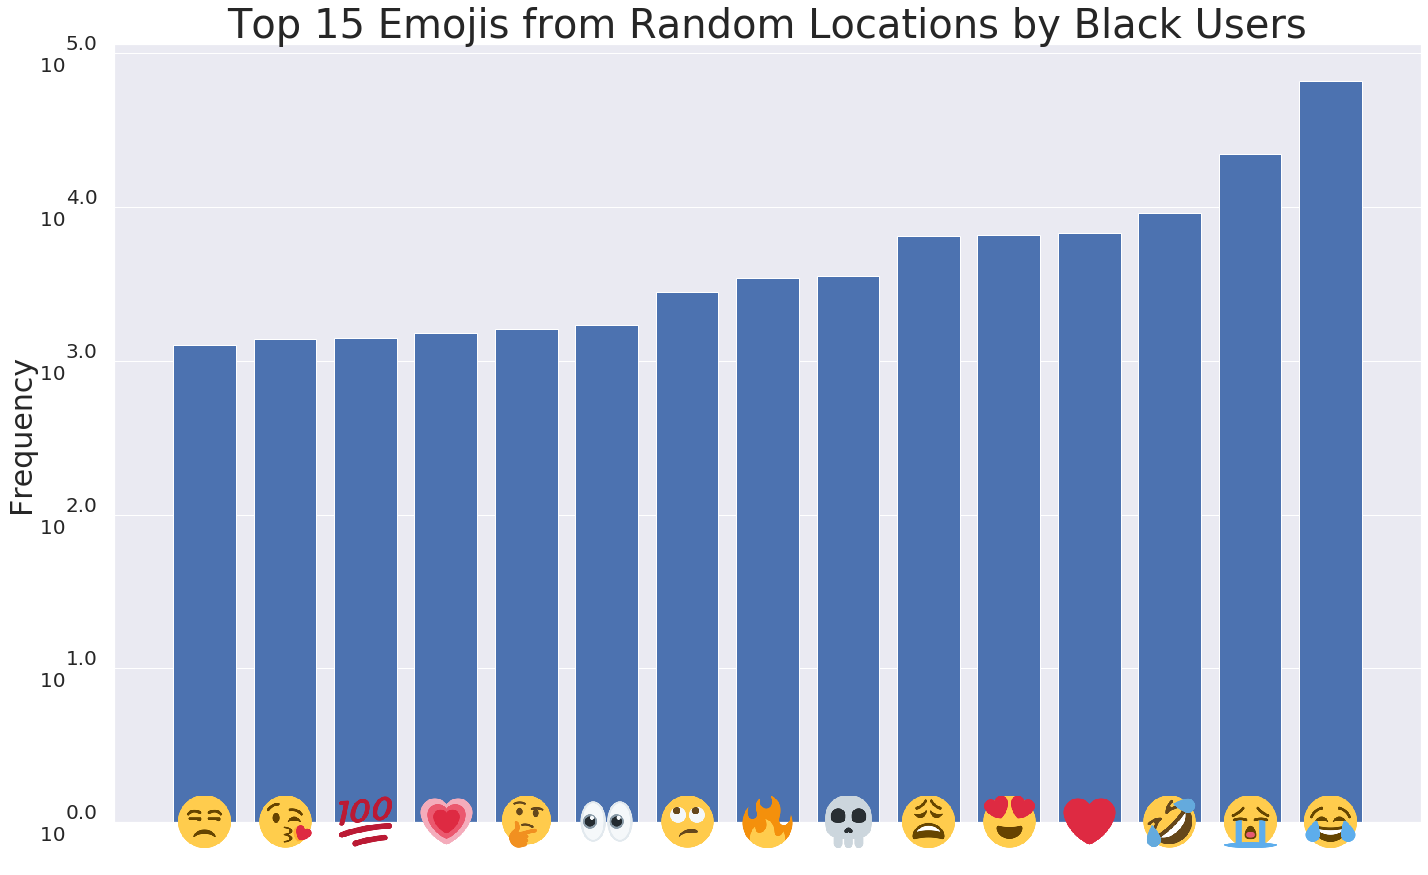

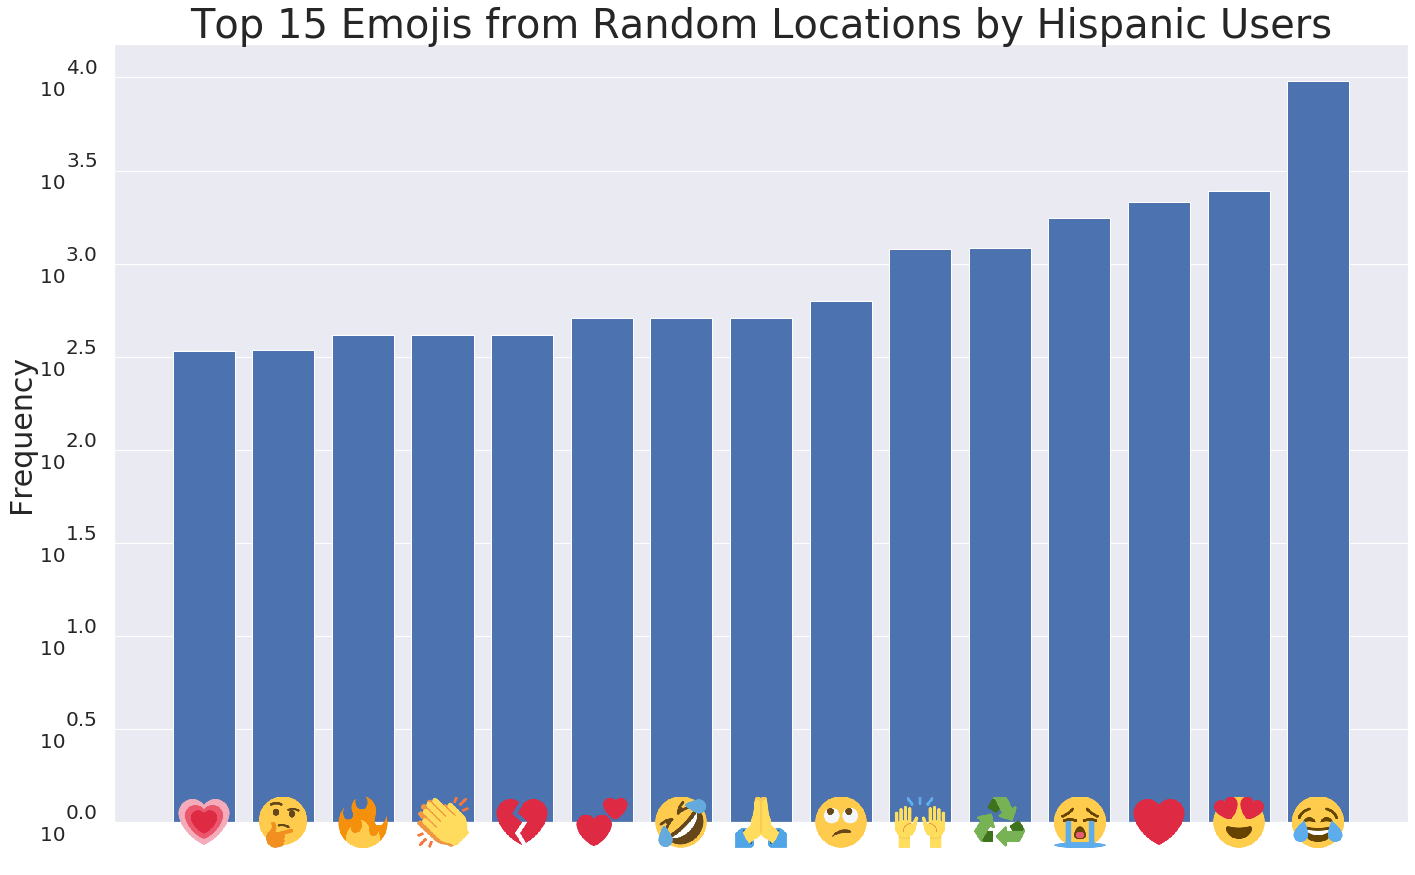

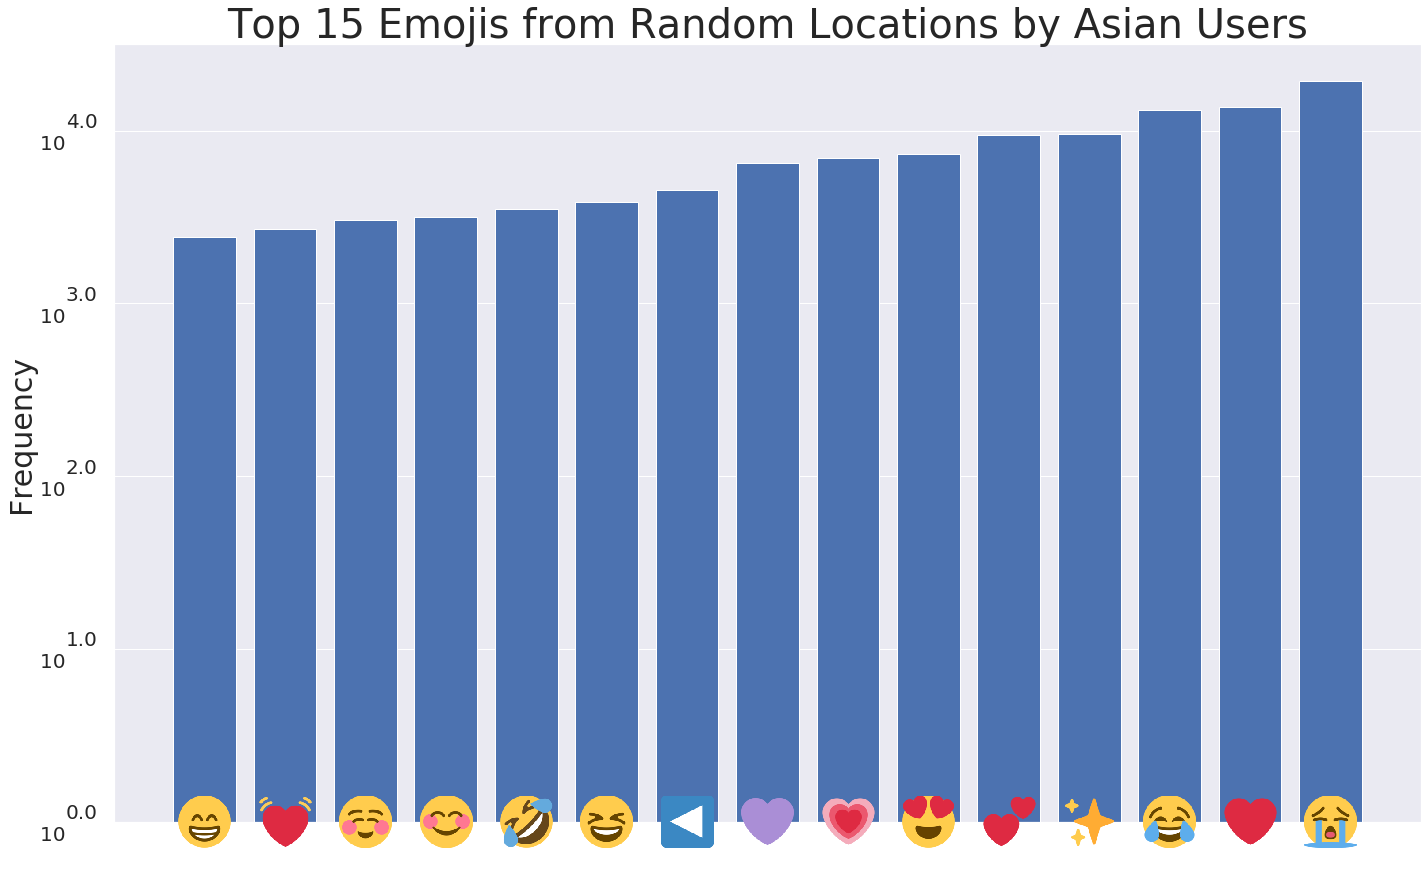

In [21]:
ethnicities_list = ['White','Black','Other','Asian']
ethnicities_values =[white_stats_df.sort_values(by=['Whites_Count']),black_stats_df.sort_values(by=['Blacks_Count']),other_stats_df.sort_values(by=['Others_Count']),asian_stats_df.sort_values(by=['Asians_Count'])]
#ethnicities_graph_colours=['dbd9d9','a3a3a3','e1b68b','ffeeb7']

for ind,ethn in enumerate(ethnicities_list):

     # Top 15 Values
    x = ethnicities_values[ind]['Emoji'].tail(15).values
    y = ethnicities_values[ind]['{}s_Count'.format(ethnicities_list[ind])].tail(15).values
    y_log = np.log10(y.astype(int))

    # Set linespacing
    x_linespace = linspace(0, 4*pi, num=15)

    # Plot Bar Chart
    fig, ax = plt.subplots(figsize=(20,12))
    ax.yaxis.set_major_formatter(formatter_pow10_1dp)
    ax.tick_params(axis='both', which='major', pad=10)
    #ax.set_facecolor('#{}'.format(ethnicities_graph_colours[ind]))
    plt.grid(linestyle='-', linewidth=1,axis='y')
    plt.bar(x_linespace, y_log, width=0.7, bottom=None, align='center')#,color =colors_indianred_fade)
    ax.get_xaxis().set_visible(False)
    plt.yticks(fontsize =20)
    plt.ylabel('Frequency', fontsize =30)
    plt.title('Top 15 Emojis from Random Locations by {} Users'.format(ethnicities_list[ind]), fontsize =40)
    if(ethnicities_list[ind] == 'Other'):
        plt.title('Top 15 Emojis from Random Locations by Hispanic Users', fontsize =40)
    plt.tight_layout()

    # Plot emojis on x-axis
    bar_chart_plot_emojis(ax,fig,x)
    plt.show()

## Top 15 Dinstict Emojis Graph by Ethnicity

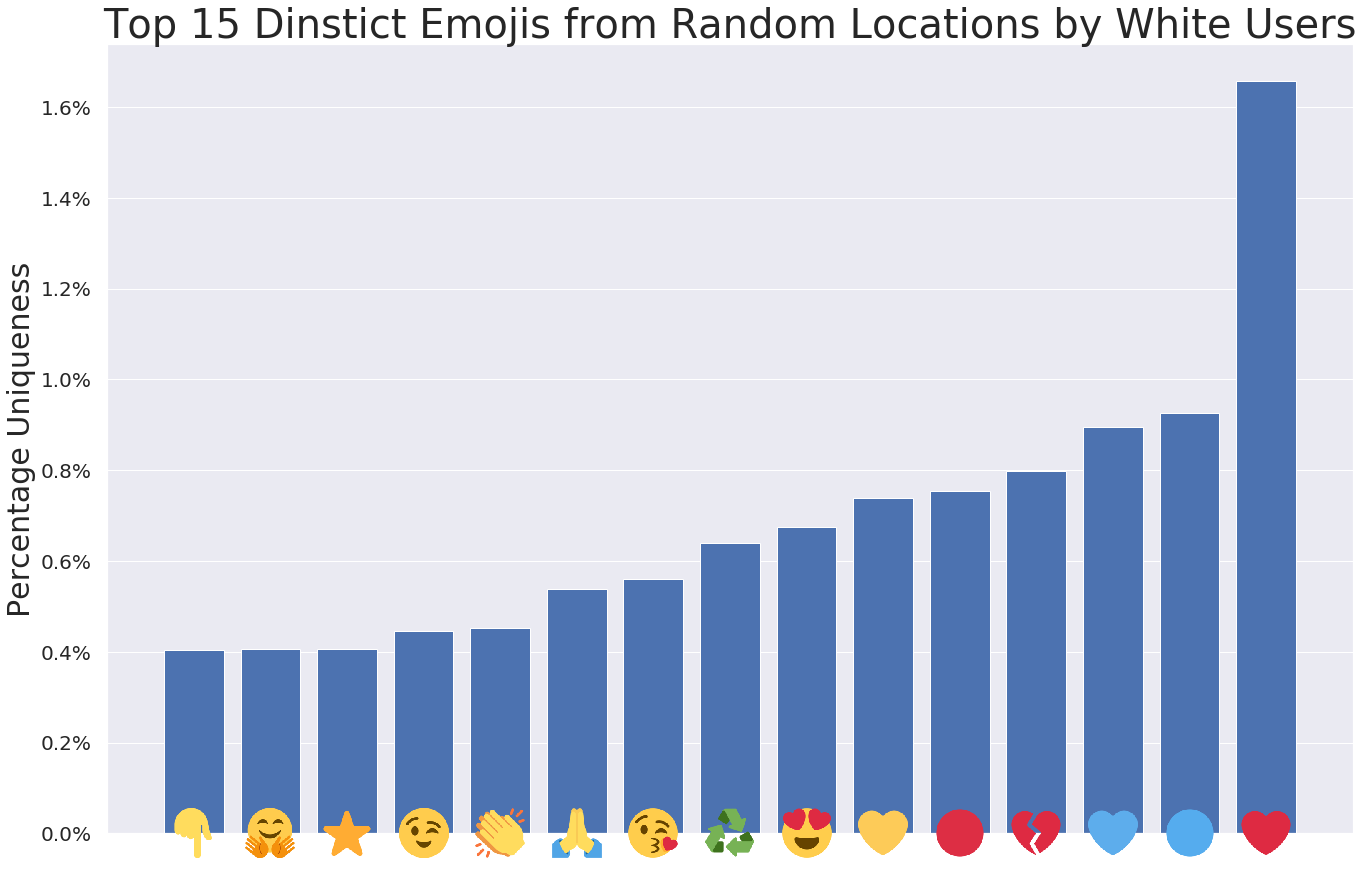

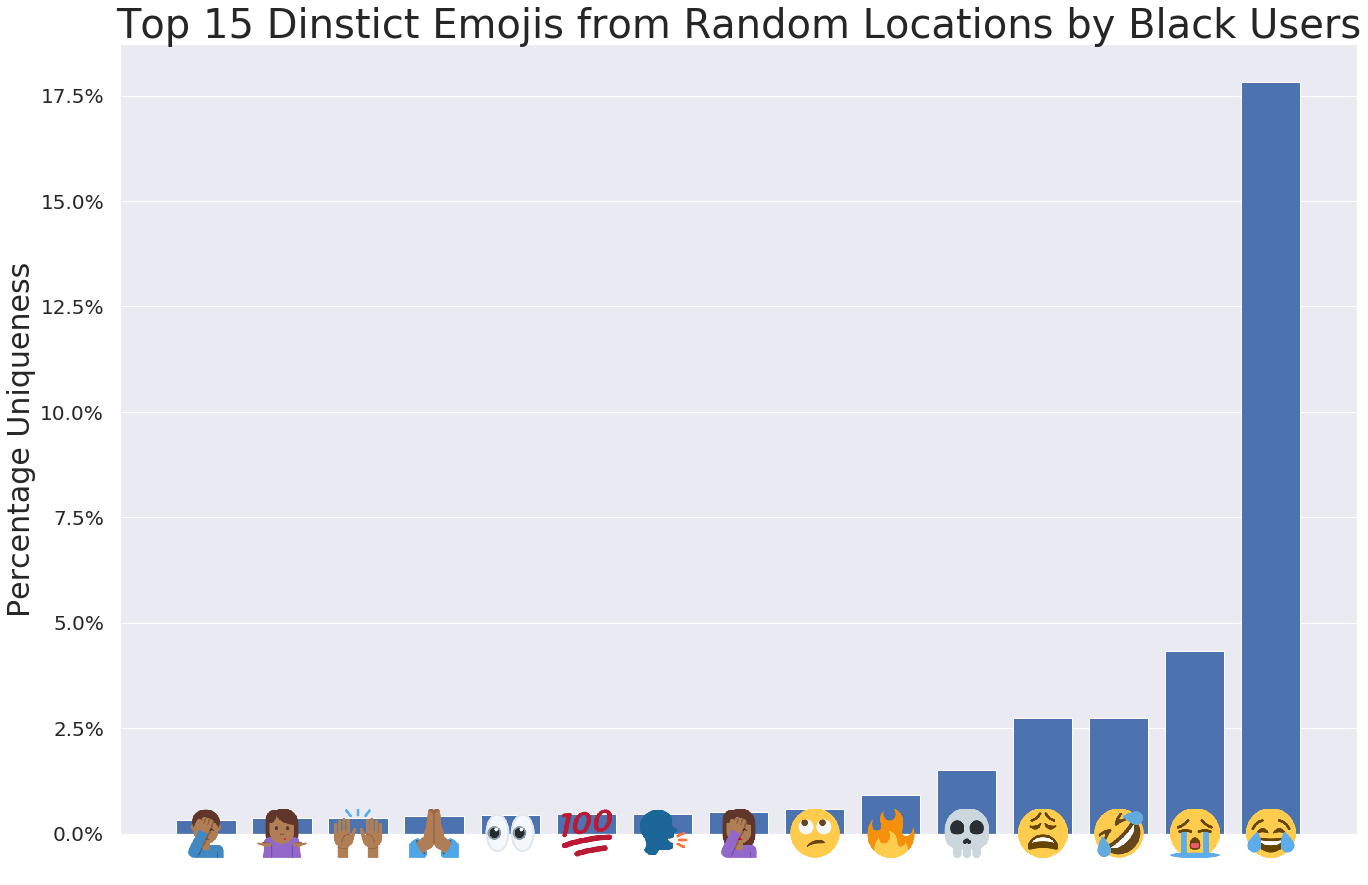

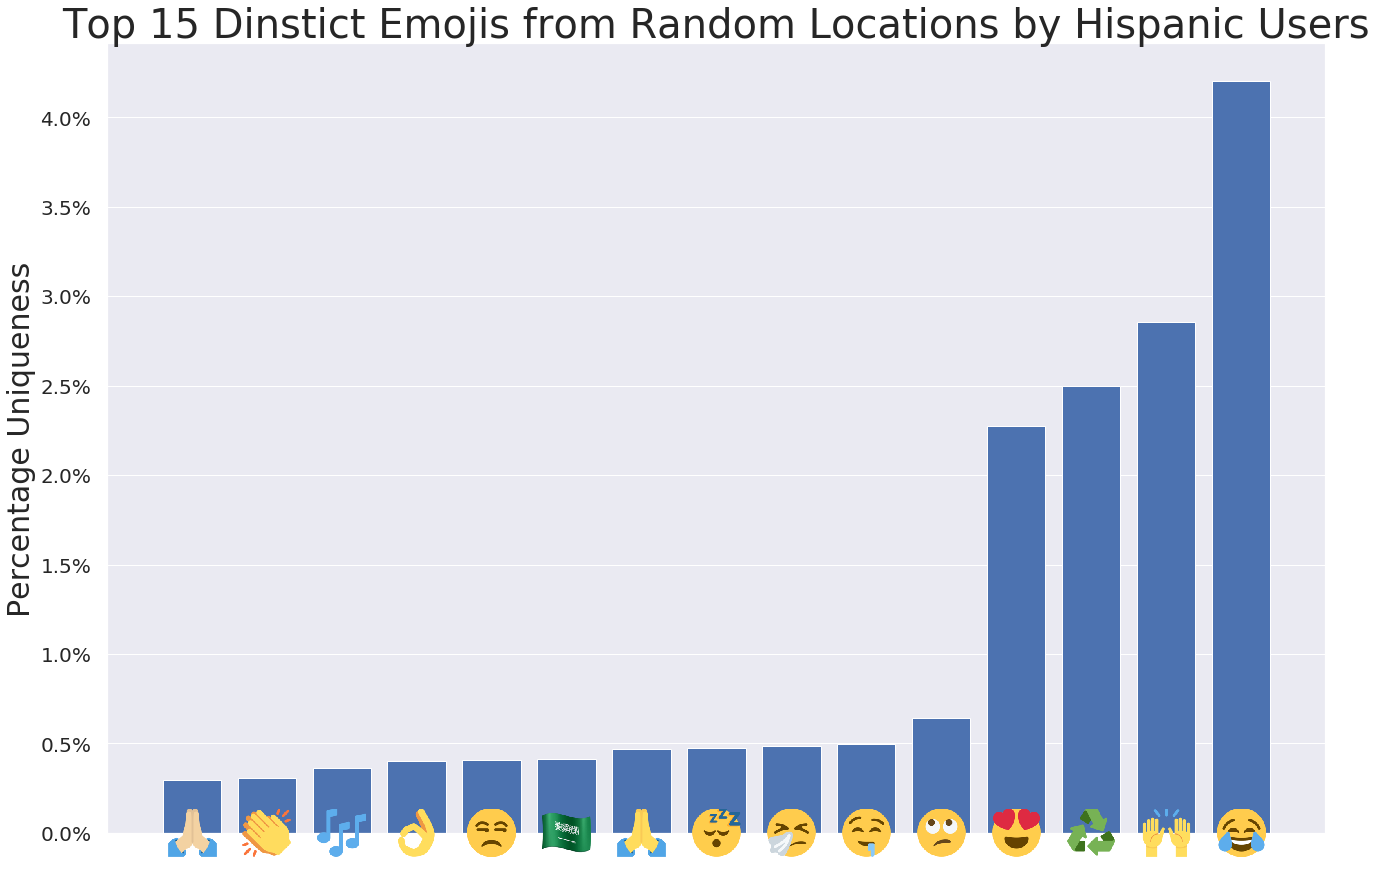

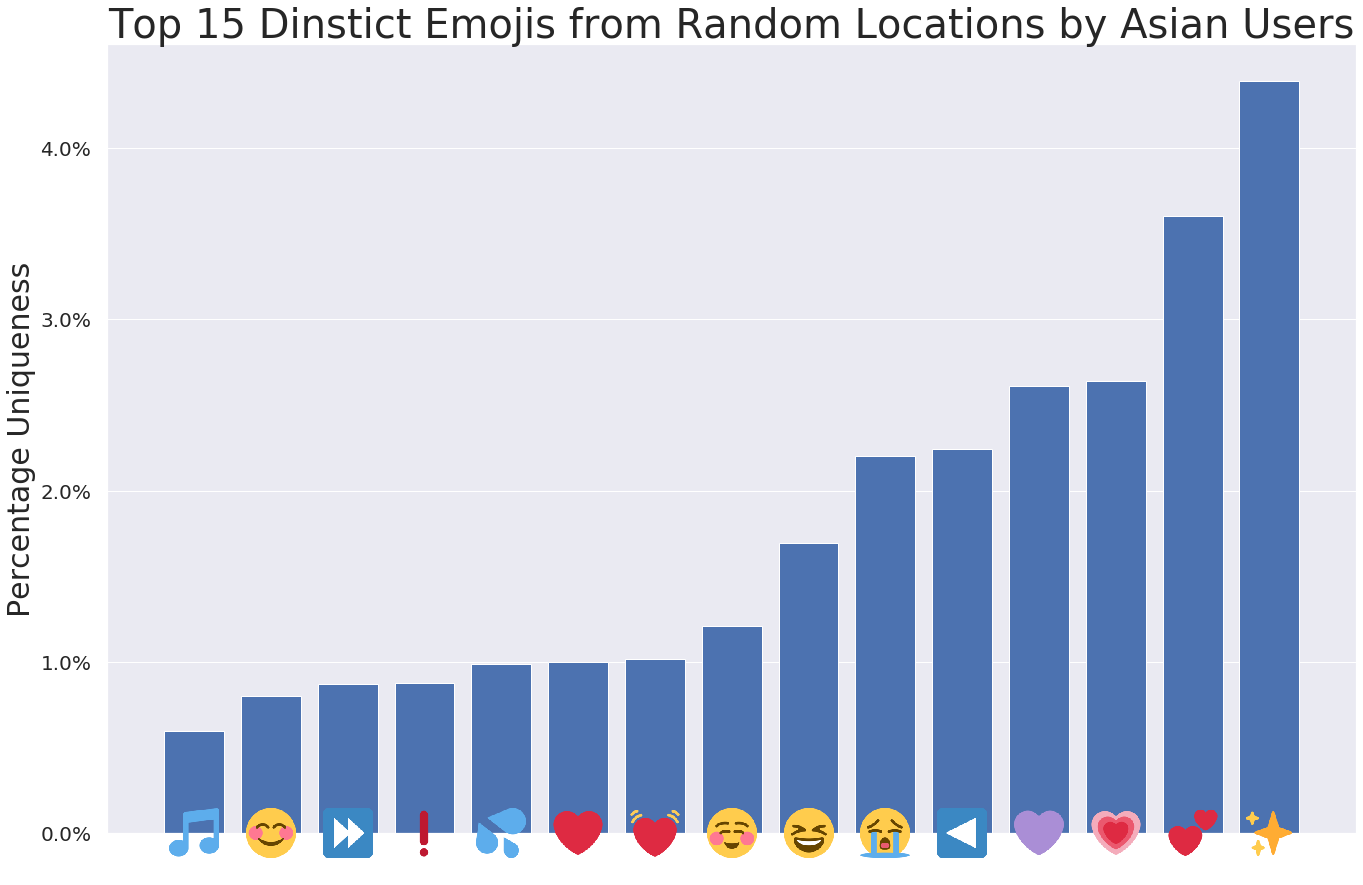

In [19]:
ethnicities_list = ['White','Black','Other','Asian']
ethnicities_values =[white_stats_df.sort_values(by=['Whites_Perc_Dif']),black_stats_df.sort_values(by=['Blacks_Perc_Dif']),other_stats_df.sort_values(by=['Others_Perc_Dif']),asian_stats_df.sort_values(by=['Asians_Perc_Dif'])]
#ethnicities_graph_colours=['dbd9d9','a3a3a3','e1b68b','ffeeb7']

for ind,ethn in enumerate(ethnicities_list):

     # Top 15 Values
    x = ethnicities_values[ind]['Emoji'].tail(15).values
    y = ethnicities_values[ind]['{}s_Perc_Dif'.format(ethnicities_list[ind])].tail(15).values

    # Set linespacing
    x_linespace = linspace(0, 4*pi, num=15)

    # Plot Bar Chart
    fig, ax = plt.subplots(figsize=(20,12))
    ax.yaxis.set_major_formatter(formatter_percentage)
    ax.tick_params(axis='both', which='major', pad=10)
    #ax.set_facecolor('#{}'.format(ethnicities_graph_colours[ind]))
    plt.grid(linestyle='-', linewidth=1,axis='y')
    plt.bar(x_linespace, y, width=0.7, bottom=None, align='center')#,color =colors_indianred_fade)
    ax.get_xaxis().set_visible(False)
    plt.yticks(fontsize =20)
    plt.ylabel('Percentage Uniqueness', fontsize =30)
    plt.title('Top 15 Dinstict Emojis from Random Locations by {} Users'.format(ethnicities_list[ind]), fontsize =40)
    if(ethnicities_list[ind] == 'Other'):
        plt.title('Top 15 Dinstict Emojis from Random Locations by Hispanic Users', fontsize =40)
    plt.tight_layout()

    # Plot emojis on x-axis
    bar_chart_plot_emojis(ax,fig,x)
    plt.show()

## Top 15 Emojis Worldwide Pie Chart

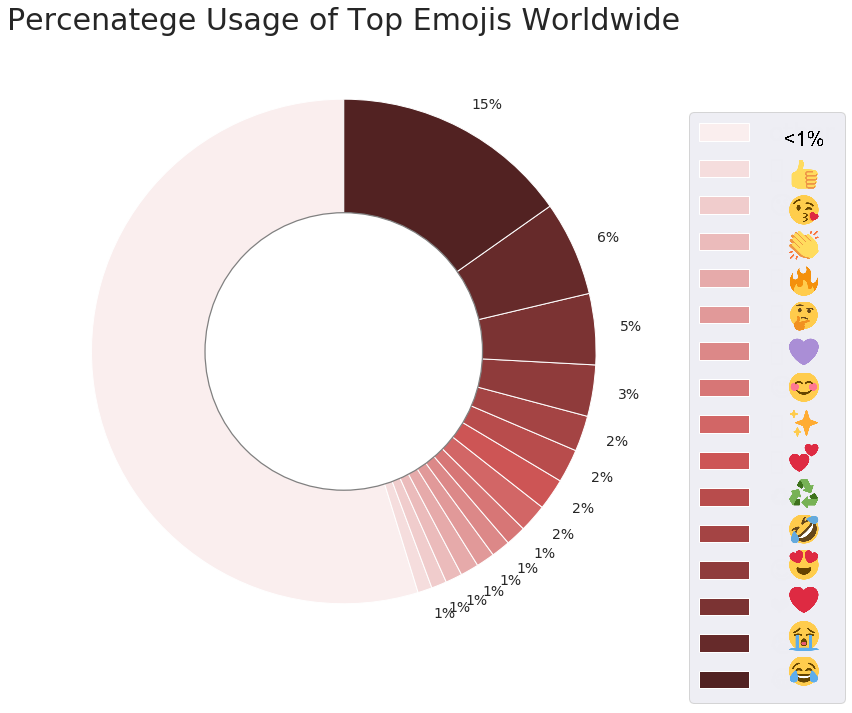

In [20]:
x = emojis_count_df['Emoji'].tail(15).values
y = (emojis_count_df['Count']/emojis_count_df['Count'].sum()).tail(15).values
fill = 1 -y.sum()
new_y = np.append([fill],y)

y_labels = []
for i,perc in enumerate (y):
    y_labels.append("{:.0f}%".format(perc*100))
# Don't show other <1%
y_labels.insert(0,"")

# Plot pie chart
fig, ax = plt.subplots(figsize=(17,12))
title = plt.title('Percenatege Usage of Top Emojis Worldwide', fontsize =30)
title.set_ha("center")
plt.gca().axis("equal")
pie = plt.pie(new_y,labels=y_labels,colors=colors_indianred_fade, startangle=90, textprops={'fontsize': 14})
legend = plt.legend(pie[0],np.append(['other'],x), bbox_to_anchor=(0.67,0.45), loc="center right", fontsize=25, 
           bbox_transform=plt.gcf().transFigure)
plt.setp(legend.get_texts(), color='#ededf3')
plt.subplots_adjust(left=0.0, bottom=0.15, right=0.5)

# Add cicrle in the center
centre_circle = plt.Circle((0,0),0.55,color='grey', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Plot emojis on legend
pie_chart_plot_emojis(ax,fig,x)
plt.show()